In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MITgcmutils as mit
import cmocean 
import xarray as xr
from scipy.spatial import cKDTree
from numba import njit
from matplotlib.colors import Normalize # Normalizeをimport
from matplotlib.colors import TwoSlopeNorm
from geopy.distance import great_circle
import cartopy.crs as ccrs
import os
import netCDF4
from matplotlib.tri import Triangulation
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter


In [2]:
fileloc_SW = '/home/tsuribeh/Forcing_data/ShortWaveFlux/'
fileloc_to_write = fileloc_SW

filename_SW = 'Incomsolar_12m_cs32.bin'

SW_ds = xr.load_dataset(fileloc_SW+'CERES_EBAF_Ed4.2_Subset_CLIM01-CLIM12.nc')


In [3]:
SW_ds

<xarray.Dataset> Size: 28MB
Dimensions:                (lon: 360, lat: 180, ctime: 12, sc1: 12, sc2: 2)
Coordinates:
  * lon                    (lon) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                    (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * ctime                  (ctime) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: sc1, sc2
Data variables:
    climatology_bounds     (sc1, sc2) int32 96B 2453737 2457055 ... 2457024
    toa_sw_all_clim        (ctime, lat, lon) float32 3MB 347.7 347.7 ... 0.047
    toa_sw_clr_c_clim      (ctime, lat, lon) float32 3MB 341.7 341.7 ... 0.011
    toa_sw_clr_t_clim      (ctime, lat, lon) float32 3MB 341.5 341.5 ... 0.011
    toa_cre_sw_clim        (ctime, lat, lon) float32 3MB -6.124 ... -0.036
    solar_clim             (ctime, lat, lon) float32 3MB 496.0 496.0 ... 0.0 0.0
    sfc_net_sw_all_clim    (ctime, lat, lon) float32 3MB 81.02 81.02 ... 0.0 0.0
    sfc_net_sw_clr_c_clim  (ctime, lat, lon) float32 3MB 94.56 94.56 ... 0.0 0.0
    sfc_net_sw_clr_t_clim  (ctime, lat, lon) float32 3MB 93.9 93.9 ... 0.0 0.0
    sfc_cre_net_sw_clim    (ctime, lat, lon) float32 3MB -12.88 -12.88 ... 0.0
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Revised data Release Date January 2, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF_L3B004.2

In [4]:
lon = SW_ds['lon']
lat = SW_ds['lat']

lon,lat = np.meshgrid(lon,lat)
lonlat= np.stack([lon,lat],axis=2)#.astype('float')


TOAShortwaveFlux_AllSky = SW_ds['toa_sw_all_clim']
TOAShortwaveFlux_ClearSky_clear = SW_ds['toa_sw_clr_c_clim']
TOAShortwaveFlux_ClearSky_total = SW_ds['toa_sw_clr_t_clim']
TOACREShortwaveFlux = SW_ds['toa_cre_sw_clim']
IncomingSolarFlux = SW_ds['solar_clim']#.astype('float')


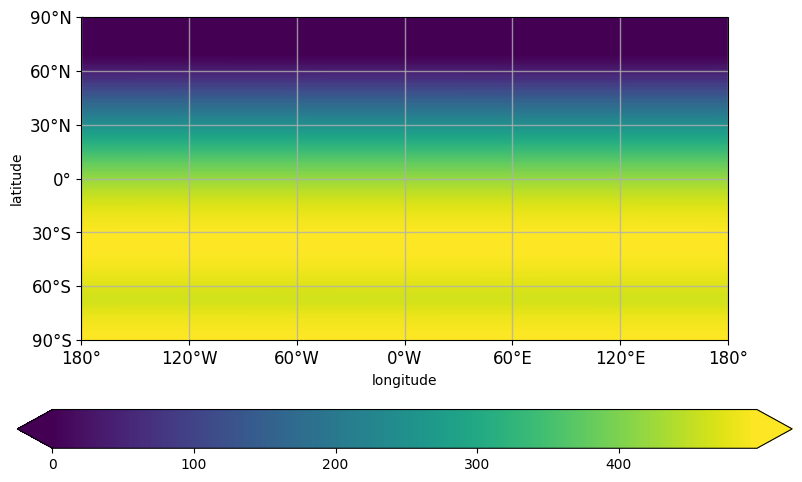

In [5]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_facecolor('gray')

# im = ax.contourf(lon,lat,TOACREShortwaveFlux[0])
# im = ax.pcolormesh(lon,lat,TOAShortwaveFlux_AllSky[0])
# im = ax.pcolormesh(lon,lat,TOAShortwaveFlux_ClearSky_clear[0] - TOAShortwaveFlux_ClearSky_total[0])
# im = ax.pcolormesh(lon,lat,TOAShortwaveFlux_ClearSky_total[0])
# im = ax.pcolormesh(lon,lat,TOACREShortwaveFlux[0])

im = ax.pcolormesh(lon,lat,IncomingSolarFlux[0])


ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

cb=fig.colorbar(im, ax=ax, extend='both',orientation='horizontal')

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

plt.show()

IncomingSolarFluxでやってみる。

In [6]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms


@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) 


    return regridded_data


In [7]:
#Directory for cs grid
fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_1/'
# CSグリッドデータの読み込み
XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
XG = mit.mds.rdmds(fileloc_csgrid+'XG')
YG = mit.mds.rdmds(fileloc_csgrid+'YG')

XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)


In [8]:
data_regridded = np.empty((12,32,192))
data_raw = np.array(IncomingSolarFlux) #numbaを使うためnumpyに

In [9]:
#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)

#regrid bathy data to CS
for k in range(12):
    data_regridded[k] = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,data_raw[k],p=2.)

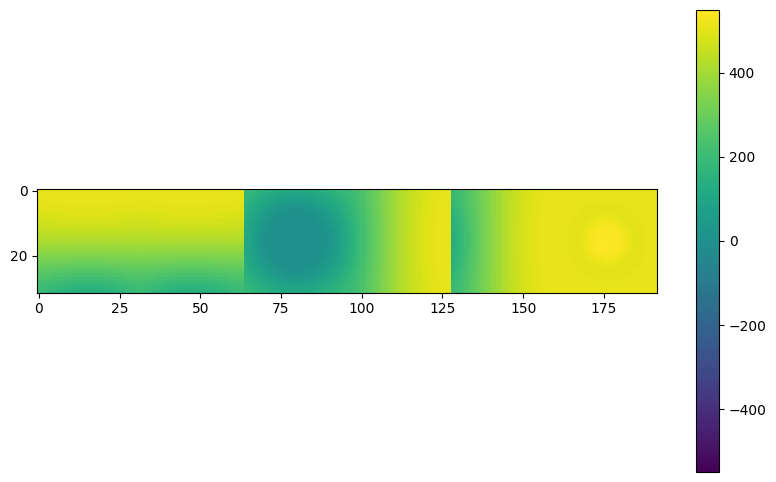

In [10]:
#check by imshow
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
norm = TwoSlopeNorm(vcenter =0)
im = ax.imshow(data_regridded[11],norm=norm)

fig.colorbar(im, ax=ax)
plt.show()

In [11]:
mit.writebin(fileloc_to_write+filename_SW, data_regridded, dataprec='float64')
